# **02 - Naive Baseline Models**

This notebook creates simple baseline forecasts for realized volatility. These baselines help establish a reference level of performance. Any advanced model should exceed these benchmarks in a measurable way.

Realized volatility used here is `rv_21`, computed earlier and saved in `modeling_dataset.csv`.  <br>
This notebook trains baselines on the training segment and evaluates them on the held out test period.

## **Objectives**

* Implement a persistence model.
* Implement rolling mean models with window sizes that represent short, medium, and slightly longer memory.
* Implement a global mean baseline.
* Use a clear time-based split.
* Evaluate with RMSE and MAE.
* Save forecasts and metrics for later comparison.

## **Imports and Configuration**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")

## **Load Data**

In [ ]:
# Load processed dataset
data_path = Path("../data/processed/modeling_dataset.csv")
df = pd.read_csv(data_path)
df["Date"] = pd.to_datetime(df["Date"])

df = df.sort_values("Date").reset_index(drop=True)

print(df.head(), "\n")
print(df.tail(), "\n")
print(df.isna().sum())

target_col = "rv_21"


        Date         Open         High          Low        Close    Adj Close  \
0 2000-02-02  1409.280029  1420.609985  1403.489990  1409.119995  1409.119995   
1 2000-02-03  1409.119995  1425.780029  1398.520020  1424.969971  1424.969971   
2 2000-02-04  1424.969971  1435.910034  1420.630005  1424.369995  1424.369995   
3 2000-02-07  1424.369995  1427.150024  1413.329956  1424.239990  1424.239990   
4 2000-02-08  1424.239990  1441.829956  1424.239990  1441.719971  1441.719971   

       Volume  log_return     rv_21  
0  1038600000   -0.000114  0.016190  
1  1146500000    0.011185  0.013915  
2  1045100000   -0.000421  0.013915  
3   918100000   -0.000091  0.013916  
4  1047700000    0.012198  0.012880   

           Date         Open         High          Low        Close  \
6496 2025-12-01  6812.299805  6843.649902  6799.939941  6812.629883   
6497 2025-12-02  6830.959961  6851.549805  6806.709961  6829.370117   
6498 2025-12-03  6815.290039  6862.419922  6810.430176  6849.720215   

## **Train-Test Split**

We use a simple time-based split with 80% of data for training. No shuffling is applied. This prevents leakage and keeps the evaluation reailstic.

In [3]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print("Train period: ", train["Date"].min(), "to", train["Date"].max())
print("Test period: ", test["Date"].min(), "to", test["Date"].max())
print("Test observations:", len(test))
print("Years of test data:", round(len(test) / 252, 2))

y_train = train[target_col].values
y_test = test[target_col].values
dates_test = test["Date"].values

Train period:  2000-02-02 00:00:00 to 2020-10-01 00:00:00
Test period:  2020-10-02 00:00:00 to 2025-12-05 00:00:00
Test observations: 1301
Years of test data: 5.16


## **Baseline Models**

We now construct the following baselines-
* Persistence: forecast tomorrow as today.
* Rolling mean with window 5.
* Rolling mean with window 10.
* Rolling mean with window 21.
* Global mean of the training set.

These baselines are simple but informative. They show how much structure an advanced model must capture to outperform naive strategies.

## Persistence Model

In [4]:
train["persistence"] = train[target_col].shift(1)
test["persistence"] = test[target_col].shift(1)

# First test forecast uses the last training value
test.loc[test.index[0],"persistence"] = train[target_col].iloc[-1]

## Rolling Mean Baselines

Rolling means are computed on the training segment. The final training rolling value is then used to forecast the entire test window. This keeps the procedure leak free.

In [5]:
for w in [5, 10, 21]:
    roll_name = f"roll_mean_{w}"
    train[roll_name] = train[target_col].rolling(w).mean()
    
    last_roll_value = train[roll_name].iloc[-1]
    test[roll_name] = last_roll_value


## Global Mean Baseline

A constant forecast equal to the mean of the training data.

In [6]:
global_mean = y_train.mean()
test["global_mean"] = global_mean


## **Evaluation Metrics**

We compute RMSE and MAE for each baseline. These metrics provide complementary views of forecast performance.

In [7]:
results = []

baseline_cols = ["persistence", "roll_mean_5", "roll_mean_10", "roll_mean_21", "global_mean"]

for col in baseline_cols:
    preds = test[col].values
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    
    results.append({
        "model": col,
        "rmse": rmse,
        "mae": mae
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

best_model = metrics_df.loc[metrics_df['rmse'].idxmin(), 'model']
best_rmse = metrics_df['rmse'].min()

print("\n=== Baseline Summary ===\n")
print(f"Lowest RMSE comes from: {best_model}")
print(f"RMSE value: {best_rmse:.6f}")


          model      rmse       mae
0   persistence  0.000698  0.000351
1   roll_mean_5  0.007216  0.006536
2  roll_mean_10  0.006772  0.006086
3  roll_mean_21  0.005747  0.005011
4   global_mean  0.004536  0.003477

=== Baseline Summary ===

Lowest RMSE comes from: persistence
RMSE value: 0.000698


### Interpretation

The baseline errors are small in absolute terms because realized volatility values are also small.  
The persistence model shows the lowest RMSE and MAE, which confirms that short term volatility changes slowly.   
Rolling averages give weaker performance because they smooth too much and react slowly to shifts.   
The global mean performs better than the rolling means, which highlights strong mean reversion in the volatility series.

## **Plot Forecasts**

A visual comparison is useful to understand how each baseline behaves across the test period.

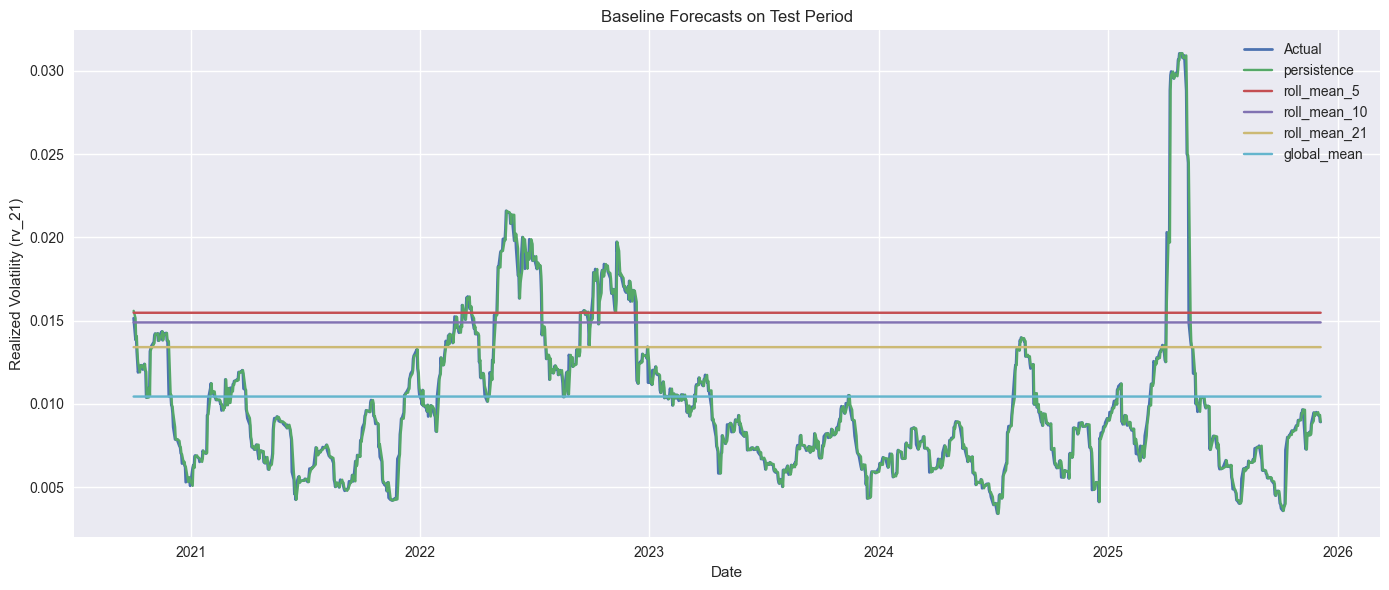

In [8]:
plt.figure(figsize=(14, 6))

plt.plot(test["Date"], y_test, label="Actual", linewidth=2)

for col in baseline_cols:
    plt.plot(test["Date"], test[col], label=col)

plt.title("Baseline Forecasts on Test Period")
plt.xlabel("Date")
plt.ylabel("Realized Volatility (rv_21)")
plt.legend()
plt.tight_layout()

fig_path = Path("../results/figures/")
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / "baseline_forecasts.png", dpi=200)
plt.show()


For a leak-free baseline, the final training rolling value is repeated across the test segment. The goal is not optimal forecasting but to provide a simple reference.

## **Save Outputs**
We save both the forecasts and the evaluation metrics for downstream comparison in later notebooks.

In [9]:
output_path = Path("../results/baselines/")
output_path.mkdir(parents=True, exist_ok=True)

# Save predictions
test_out = test[["Date", target_col] + baseline_cols]
test_out.to_csv(output_path / "baseline_forecasts.csv", index=False)

# Save metrics
metrics_df.to_csv(output_path / "baseline_metrics.csv", index=False)

test_out.head(), metrics_df


(           Date     rv_21  persistence  roll_mean_5  roll_mean_10  \
 5200 2020-10-02  0.015151     0.015589     0.015475      0.014895   
 5201 2020-10-05  0.013848     0.015151     0.015475      0.014895   
 5202 2020-10-06  0.014067     0.013848     0.015475      0.014895   
 5203 2020-10-07  0.013131     0.014067     0.015475      0.014895   
 5204 2020-10-08  0.012524     0.013131     0.015475      0.014895   
 
       roll_mean_21  global_mean  
 5200      0.013412     0.010445  
 5201      0.013412     0.010445  
 5202      0.013412     0.010445  
 5203      0.013412     0.010445  
 5204      0.013412     0.010445  ,
           model      rmse       mae
 0   persistence  0.000698  0.000351
 1   roll_mean_5  0.007216  0.006536
 2  roll_mean_10  0.006772  0.006086
 3  roll_mean_21  0.005747  0.005011
 4   global_mean  0.004536  0.003477)

## **Conclusion**

This notebook establishes a reference set of volatility forecasts. These simple models are important for interpreting the performance of more advanced models. Future notebooks will build on this foundation with GARCH models, neural networks, and alternative volatility features.